In [1]:
pip install obspy numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Trace count: 2481
Sampling rate: 83333.33 Hz


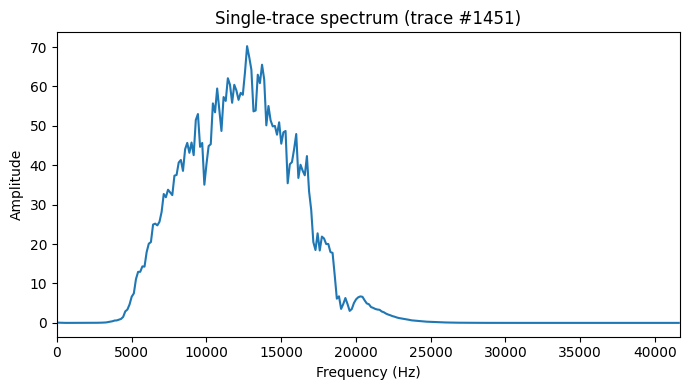

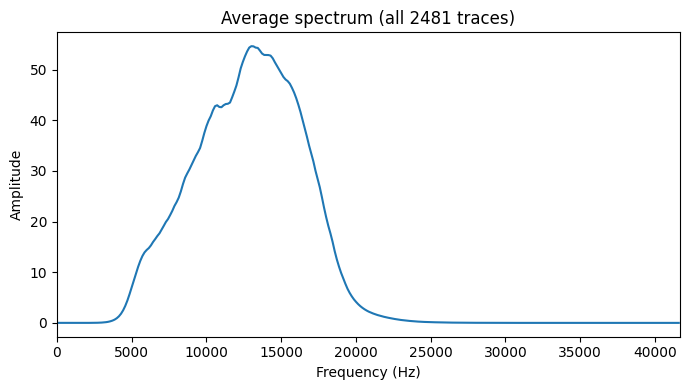

In [36]:
# pip install obspy numpy scipy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from obspy.io.segy.segy import _read_segy

# ===== 1) 读取 SEG-Y =====
SEGY_PATH = "processed/output_bp_5k_20k.sgy"  # ← 改成你的文件路径
sf = _read_segy(SEGY_PATH, headonly=False)
print("Trace count:", len(sf.traces))

# 采样间隔 -> 采样率（做兜底）
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0: return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0: return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in header; use fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)
fs = 1000.0 / dt_ms   # Hz
print(f"Sampling rate: {fs:.2f} Hz")

# 自适应 welch：确保 noverlap < nperseg 且 nperseg <= N
def welch_amp(x, fs, target_nperseg=2048, overlap_ratio=0.5):
    x = np.asarray(x, float)
    x = x - np.mean(x)
    N = len(x)
    nperseg = int(min(target_nperseg, N))
    # 至少 8 点以避免极端短窗
    nperseg = max(nperseg, 8)
    noverlap = int(nperseg * overlap_ratio)
    # 强制 noverlap < nperseg
    if noverlap >= nperseg:
        noverlap = max(0, nperseg - 1)
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=noverlap)
    amp = np.sqrt(Pxx)  # 幅度谱
    return f, amp

# ===== 2) 单道频谱 =====
trace_idx = 1450  # 想看的道号（从 0 开始）
tr = sf.traces[trace_idx].data
f1, A1 = welch_amp(tr, fs, target_nperseg=2048, overlap_ratio=0.5)

plt.figure(figsize=(7,4))
plt.plot(f1, A1)
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"Single-trace spectrum (trace #{trace_idx+1})")
plt.tight_layout()
plt.show()

# ===== 3) 全道平均频谱（更稳，用来定 band-pass）=====
amps = []
# 如果数据很多，可改成取样：for i in range(0, len(sf.traces), 5):
for i in range(len(sf.traces)):
    xi = sf.traces[i].data
    f_avg, Ai = welch_amp(xi, fs, target_nperseg=2048, overlap_ratio=0.5)
    amps.append(Ai)
A_avg = np.sqrt(np.mean(np.array(amps), axis=0)**2)  # 平均功率再开方

plt.figure(figsize=(7,4))
plt.plot(f_avg, A_avg)
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title(f"Average spectrum (all {len(sf.traces)} traces)")
plt.tight_layout()
plt.show()

## save bandpass

In [35]:
# pip install obspy segyio numpy scipy
import os, numpy as np, segyio
from obspy.io.segy.segy import _read_segy
from scipy.signal import butter, sosfiltfilt

src = "MMT(2015)_sgy/X-12_20150928_133437_RAW_LF.sgy"                               # ← 改成你的源文件
dst = "processed/output_bp_5k_20k.sgy"          # 目标文件（会新建）
os.makedirs(os.path.dirname(dst), exist_ok=True)

# 1) 读入（ObsPy 支持变长道）
sf = _read_segy(src, headonly=False)
n_tr = len(sf.traces)

# 采样间隔（微秒）
dt_us = sf.binary_file_header.sample_interval_in_microseconds
if not dt_us or dt_us <= 0:
    # 兜底：从第一条道的 stats 读取（单位: 秒）
    dt_us = int(sf.traces[0].stats.delta * 1e6)

fs  = 1e6 / dt_us
nyq = fs / 2

# 2) 组 2D 数组并补零到同一长度
lengths = [tr.data.size for tr in sf.traces]
ns_max  = max(lengths)
data    = np.zeros((ns_max, n_tr), dtype=np.float32)
for i, tr in enumerate(sf.traces):
    d = tr.data.astype(np.float32)
    data[:d.size, i] = d

# 3) 设计带通并滤波（对每列=每道做零相位滤波）
f_low, f_high = 5000.0, 20000.0
f1 = max(1.0,  min(f_low,  nyq*0.95))
f2 = max(f1*1.05, min(f_high, nyq*0.95))
sos = butter(4, [f1/nyq, f2/nyq], btype="band", output="sos")

# 某些很短的道可能不够 filtfilt 的 padlen，这里做保护
def safe_bp(x):
    try:
        return sosfiltfilt(sos, x, axis=0)
    except Exception:
        # 遇到极短道：退化为单向滤波，避免崩溃
        from scipy.signal import sosfilt
        return sosfilt(sos, x, axis=0)

data_bp = safe_bp(data)

# 4) 写成新的定长 SEG-Y（注意 from_array 需要形状 (n_traces, ns)）
segyio.tools.from_array(dst, data_bp.T, dt=int(dt_us))
with segyio.open(dst, "r+") as f:
    f.text[0] = segyio.tools.wrap(
        f"BANDPASS {int(f1)}–{int(f2)} Hz via sosfiltfilt; padded to ns={ns_max}"
    )

print("Done ->", dst)

Done -> processed/output_bp_5k_20k.sgy


/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/Users/haonanzhang/Library/Python/3.9/lib/python/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


## Apply bandpass filtering

Trace count: 2481, fs = 83333.3 Hz, Nyquist = 41666.7 Hz


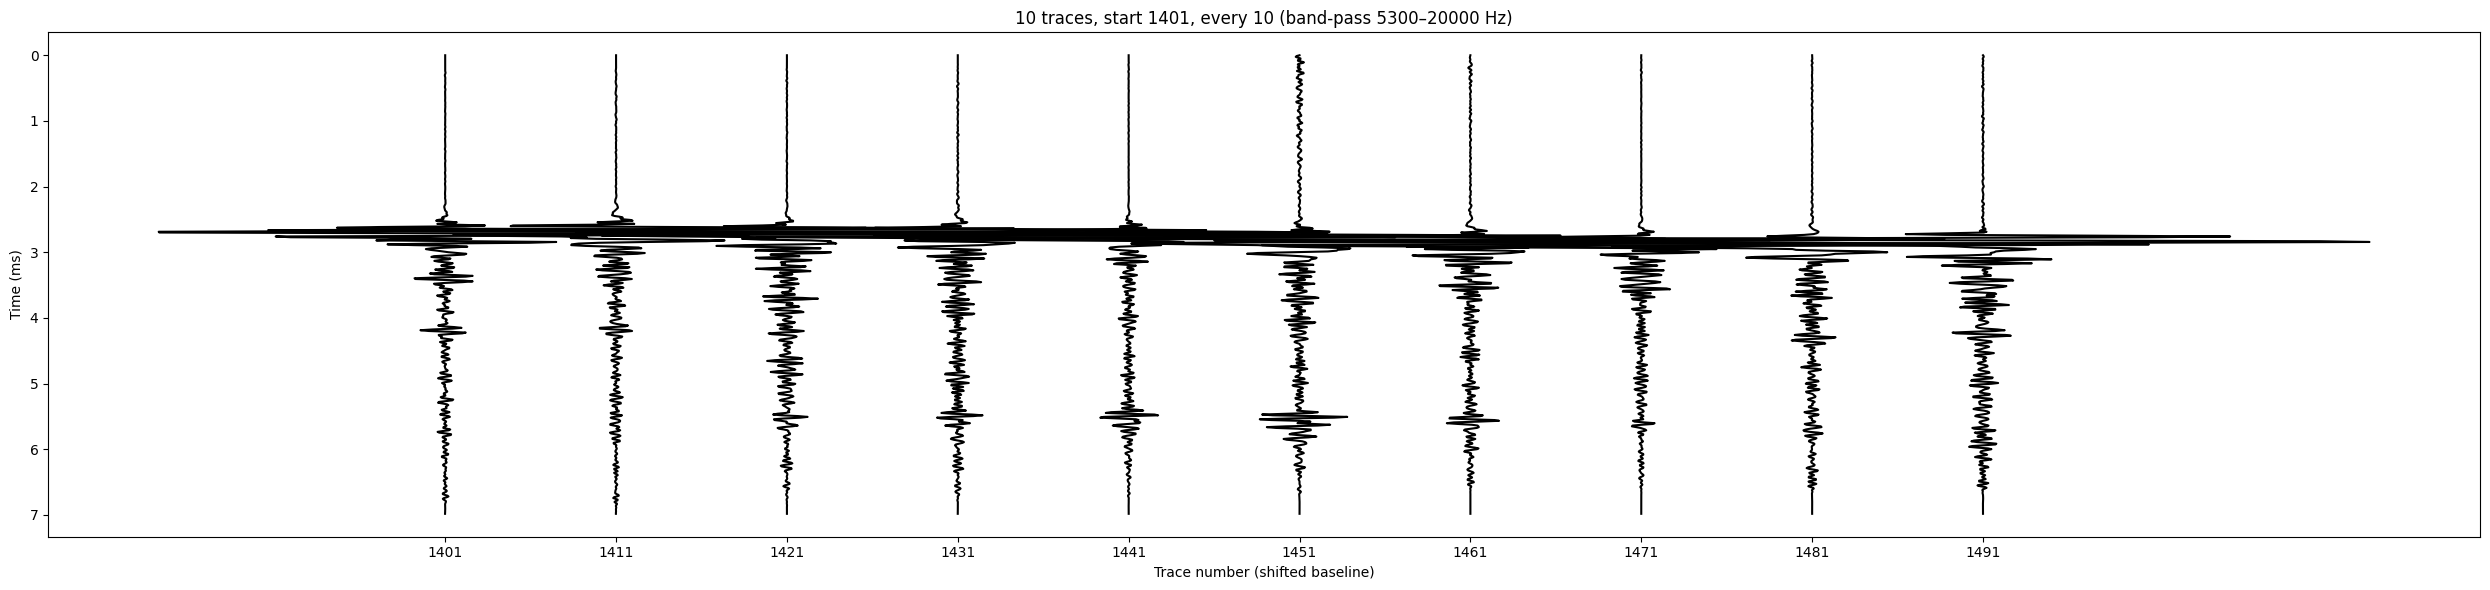

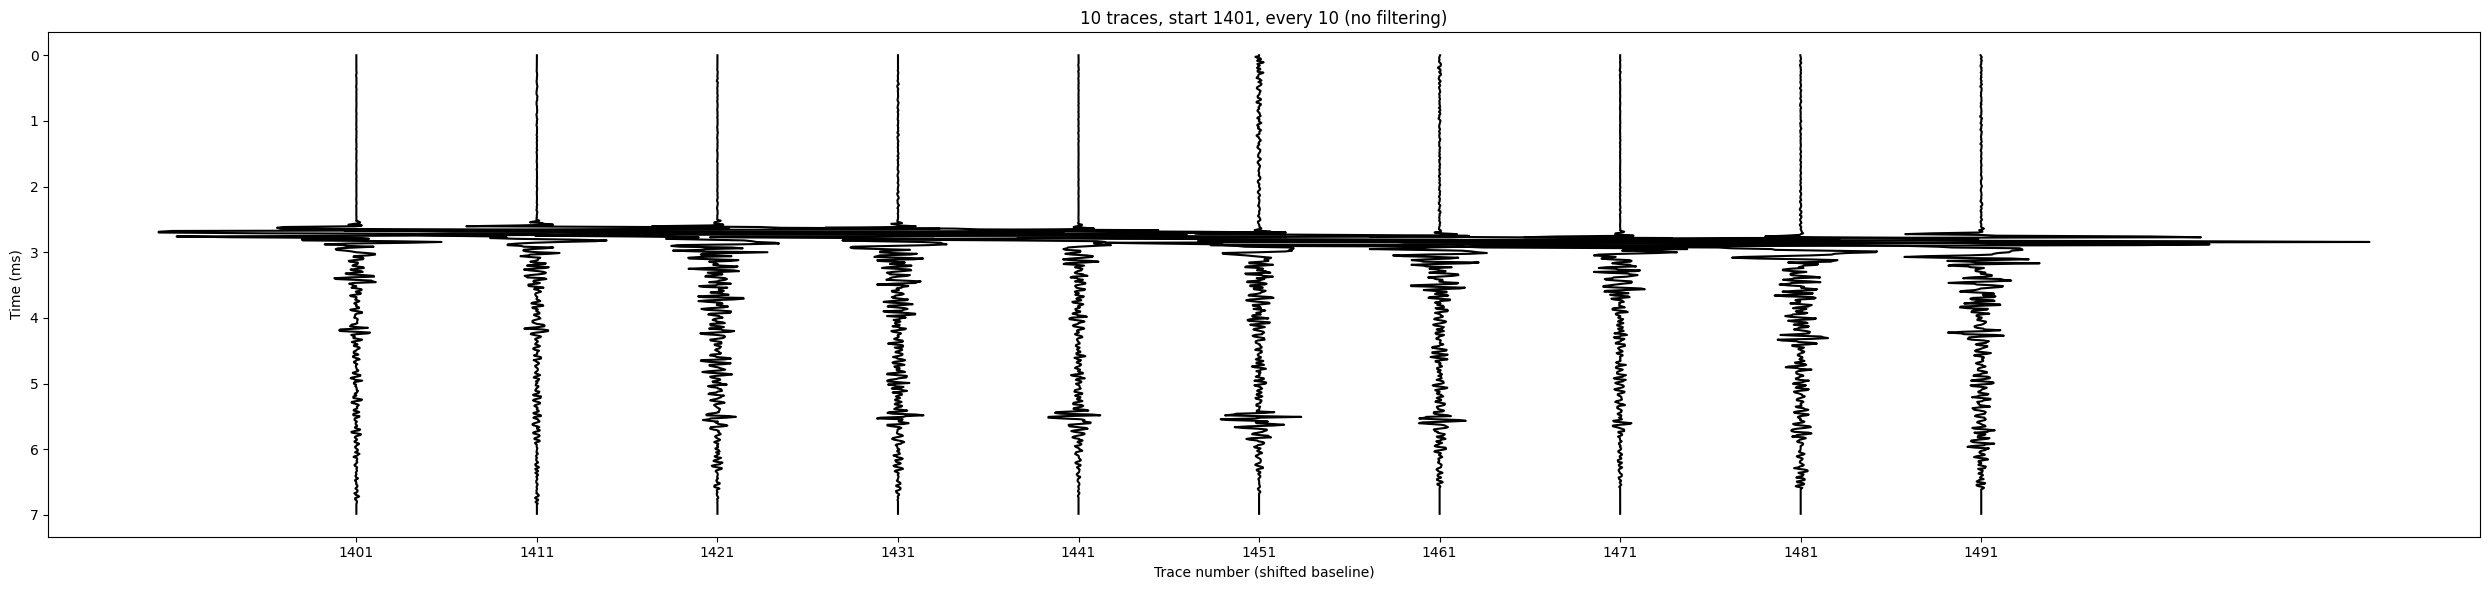

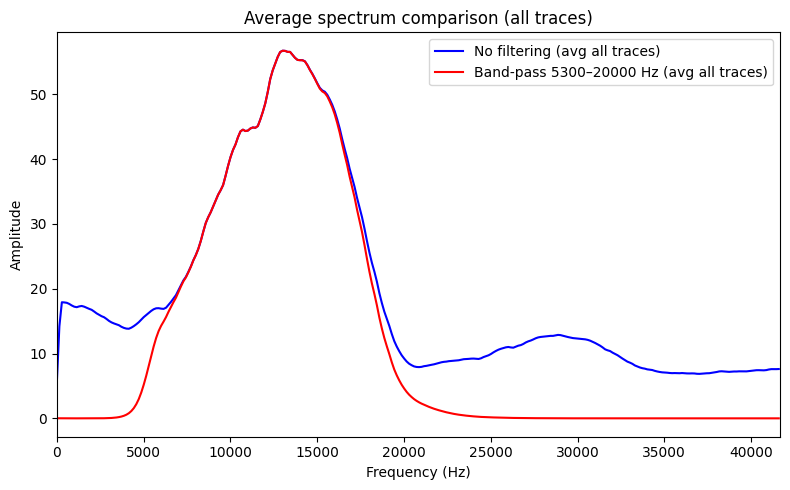

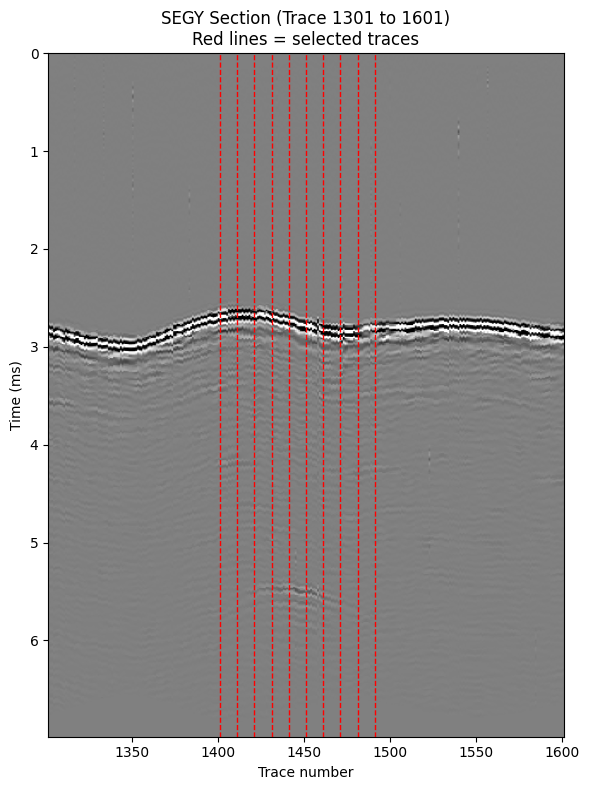

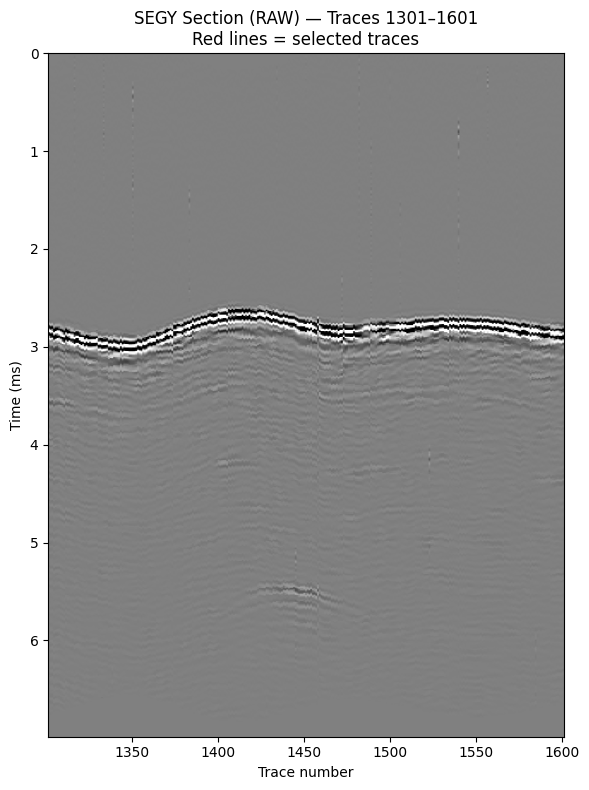

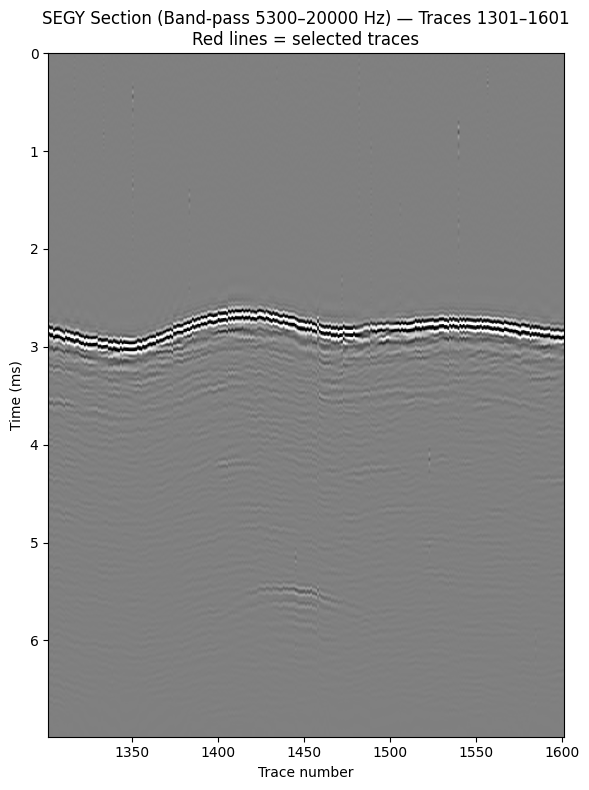

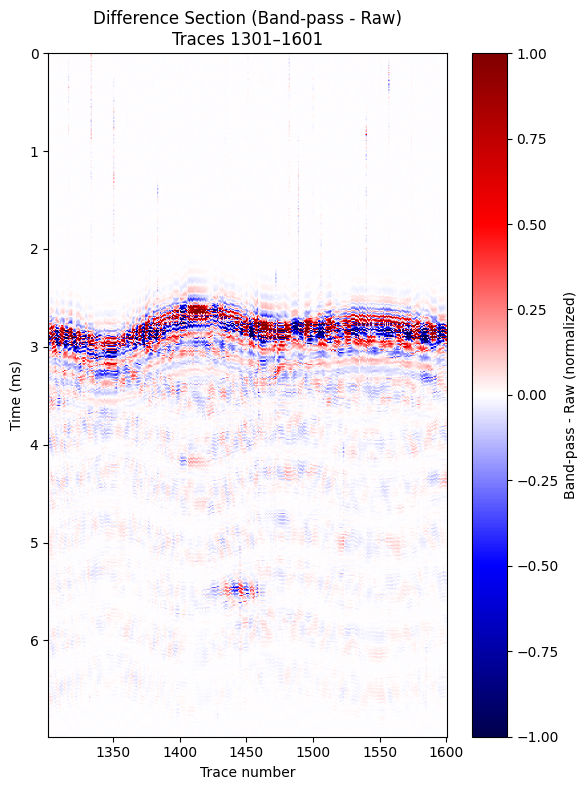

In [32]:
# pip install obspy numpy scipy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch
from obspy.io.segy.segy import _read_segy

# ====== 读取 SEG-Y ======
SEGY_PATH = "MMT(2015)_sgy/X-12_20150928_133437_RAW_LF.sgy"  # ← 改成你的文件
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)

def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0: return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0: return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in header; using fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)
fs = 1000.0 / dt_ms
print(f"Trace count: {n_traces}, fs = {fs:.1f} Hz, Nyquist = {fs/2:.1f} Hz")

# ====== 带通滤波器 ======
f_low, f_high = 5300.0, 20000.0
nyq = fs / 2.0
f1 = max(1.0, min(f_low,  nyq*0.95))
f2 = max(f1*1.05, min(f_high, nyq*0.95))
sos = butter(4, [f1/nyq, f2/nyq], btype="band", output="sos")

def bandpass_trace(x):
    return sosfiltfilt(sos, x.astype(np.float32), axis=0)

# ====== Wiggle trace indices ======
trace_start = 1400   # starting trace
step        = 10     # gap
n_waveforms = 10     # number of traces to draw
trace_indices = [trace_start + i*step for i in range(n_waveforms) if trace_start + i*step < n_traces]

# ====== Wiggle plot 函数 ======
def plot_wiggles(indices, filtered=False, amp_scale=2000, baseline_gap=2000, title_suffix=""):
    plt.figure(figsize=(25, 6))
    for k, idx in enumerate(indices):
        tr = sf.traces[idx].data.astype(np.float32)
        if filtered:
            tr = bandpass_trace(tr)
        t = np.arange(tr.size) * dt_ms
        p99 = np.percentile(np.abs(tr), 99)
        if p99 > 0: tr = tr / p99
        plt.plot(-tr * amp_scale + k*baseline_gap, t, color="black")

    plt.xticks(
        ticks=[k*baseline_gap for k in range(len(indices))],
        labels=[idx+1 for idx in indices]
    )
    plt.gca().invert_yaxis()
    plt.xlabel("Trace number (shifted baseline)")
    plt.ylabel("Time (ms)")
    plt.title(f"{len(indices)} traces, start {indices[0]+1}, every {step} {title_suffix}".strip())
    plt.tight_layout()
    plt.show()

# ====== 对比 Wiggle ======
plot_wiggles(trace_indices, filtered=True,
             amp_scale=2000, baseline_gap=2000,
             title_suffix=f"(band-pass {int(f1)}–{int(f2)} Hz)")
plot_wiggles(trace_indices, filtered=False,
             amp_scale=2000, baseline_gap=2000,
             title_suffix="(no filtering)")

# ====== 平均频谱（原始 vs 带通） ======
def average_spectrum(traces, fs, bandpass=False, step=5):
    amps = []
    for i in range(0, len(traces), step):
        tr = traces[i].data.astype(np.float32)
        if bandpass: tr = bandpass_trace(tr)
        tr = tr - np.mean(tr)
        N = len(tr)
        nperseg = min(2048, N)
        noverlap = max(0, nperseg//2 - 1)
        f, Pxx = welch(tr, fs=fs, nperseg=nperseg, noverlap=noverlap)
        amps.append(Pxx)
    A_avg = np.sqrt(np.mean(amps, axis=0))
    return f, A_avg

f_raw, A_raw = average_spectrum(sf.traces, fs, bandpass=False, step=5)
f_filt, A_filt = average_spectrum(sf.traces, fs, bandpass=True, step=5)

plt.figure(figsize=(8,5))
plt.plot(f_raw, A_raw, color="blue", label="No filtering (avg all traces)")
plt.plot(f_filt, A_filt, color="red", label=f"Band-pass {int(f1)}–{int(f2)} Hz (avg all traces)")
plt.xlim(0, fs/2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Average spectrum comparison (all traces)")
plt.legend()
plt.tight_layout()
plt.show()

# ====== 2D 剖面图（选定范围） ======
start_trace = 1300
end_trace   = 1600
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

# 把数据读成 section
lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section = np.zeros((ns, n_show), dtype=np.float32)
for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section[:d.size, j] = d
times_ms = np.arange(ns) * dt_ms

# 简单归一化
p99 = np.percentile(np.abs(section), 99)
if p99 > 0: section = np.clip(section / p99, -1, 1)

plt.figure(figsize=(6, 8))
extent = [start_trace+1, end_trace+1, times_ms[-1], 0]
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
# 标记 wiggle 里选的 trace
for idx in trace_indices:
    if start_trace <= idx <= end_trace:
        plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Trace {start_trace+1} to {end_trace+1})\nRed lines = selected traces")
plt.tight_layout()
plt.show()
# ==== 构造 2D section（未滤波）====
start_trace = 1300
end_trace   = 1600
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section_raw = np.zeros((ns, n_show), dtype=np.float32)
for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section_raw[:d.size, j] = d
times_ms = np.arange(ns) * dt_ms

# ==== 构造 2D section（带通后）====
section_bp = np.zeros_like(section_raw)
for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section_bp[:d.size, j] = bandpass_trace(d)

# ==== 统一对比度（用两幅数据的联合 p99 做归一化）====
p99 = np.percentile(np.abs(np.concatenate([section_raw.ravel(), section_bp.ravel()])), 99)
if p99 > 0:
    section_raw_disp = np.clip(section_raw / p99, -1, 1)
    section_bp_disp  = np.clip(section_bp  / p99, -1, 1)
else:
    section_raw_disp = section_raw
    section_bp_disp  = section_bp

extent = [start_trace+1, end_trace+1, times_ms[-1], 0]

# ==== 图1：未滤波 2D 剖面 ====
plt.figure(figsize=(6, 8))
plt.imshow(section_raw_disp, aspect='auto', extent=extent, cmap="gray")
# for idx in trace_indices:
#     if start_trace <= idx <= end_trace:
#         plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (RAW) — Traces {start_trace+1}–{end_trace+1}\nRed lines = selected traces")
plt.tight_layout()
plt.show()

# ==== 图2：带通后 2D 剖面（5–20 kHz；或你的 f1–f2） ====
plt.figure(figsize=(6, 8))
plt.imshow(section_bp_disp, aspect='auto', extent=extent, cmap="gray")
# for idx in trace_indices:
#     if start_trace <= idx <= end_trace:
#         plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Band-pass {int(f1)}–{int(f2)} Hz) — Traces {start_trace+1}–{end_trace+1}\nRed lines = selected traces")
plt.tight_layout()
plt.show()
# ==== 差分剖面 ====
section_diff = section_bp - section_raw

# 归一化（用差分自己的 p99）
p99_diff = np.percentile(np.abs(section_diff), 99)
if p99_diff > 0:
    section_diff_disp = np.clip(section_diff / p99_diff, -1, 1)
else:
    section_diff_disp = section_diff

plt.figure(figsize=(6, 8))
extent = [start_trace+1, end_trace+1, times_ms[-1], 0]
plt.imshow(section_diff_disp, aspect='auto', extent=extent, cmap="seismic", vmin=-1, vmax=1)
# for idx in trace_indices:
#     if start_trace <= idx <= end_trace:
#         plt.axvline(idx+1, color='black', linestyle='--', linewidth=1)
plt.colorbar(label="Band-pass - Raw (normalized)")
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"Difference Section (Band-pass - Raw)\nTraces {start_trace+1}–{end_trace+1}")
plt.tight_layout()
plt.show()

## Apply Time Gain Control

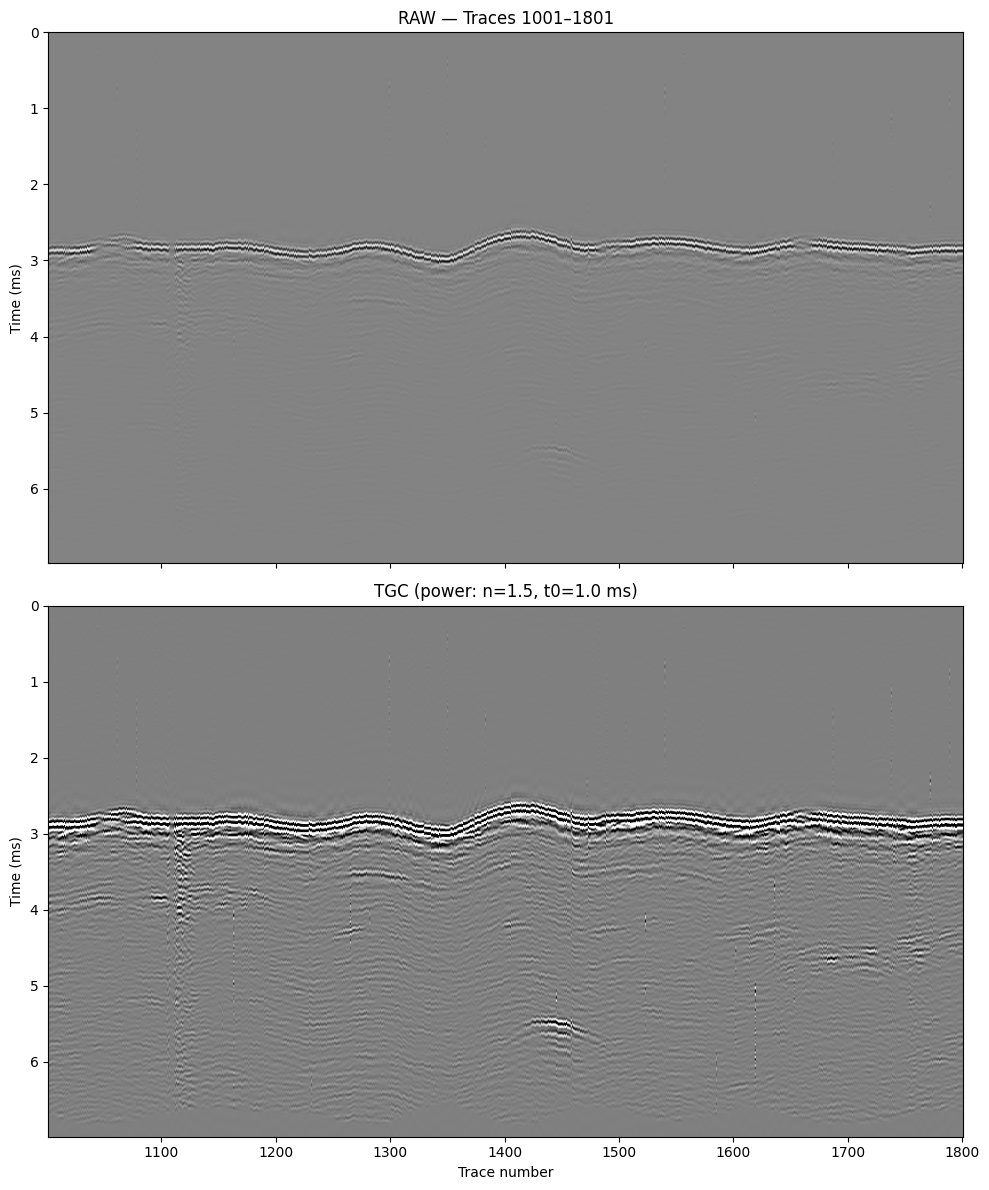

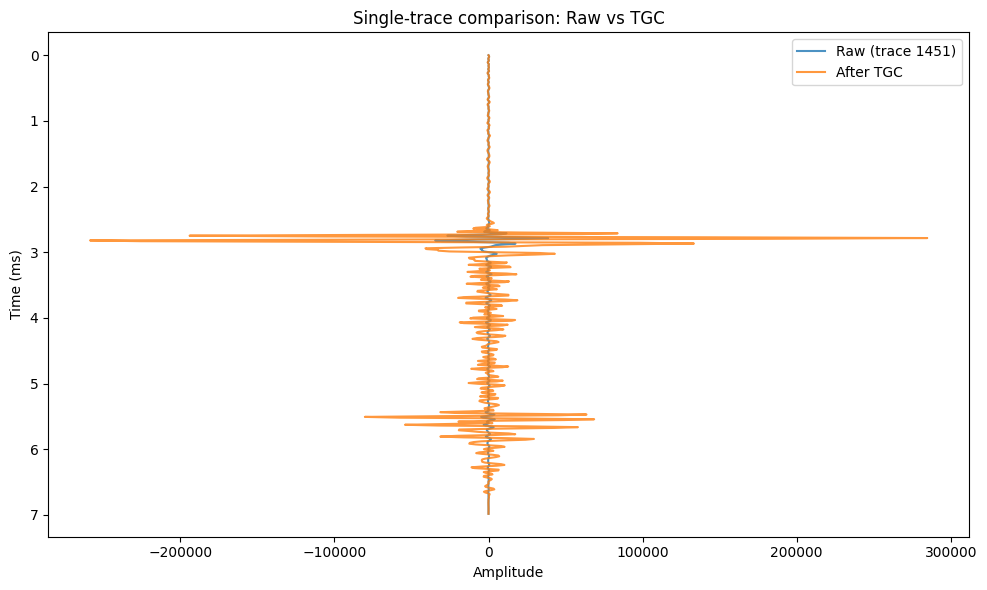

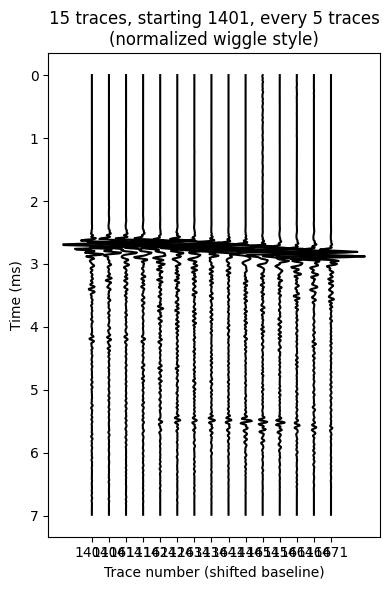

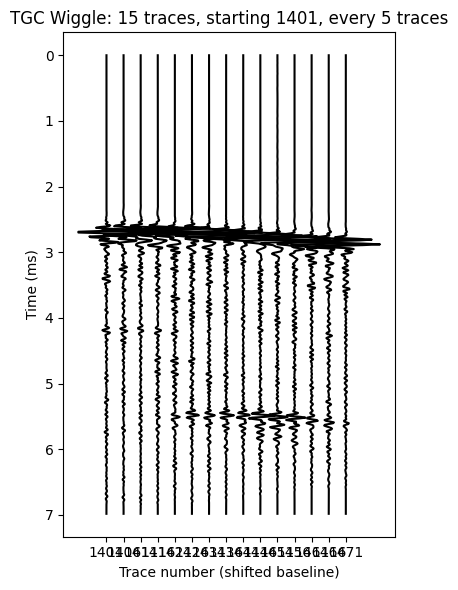

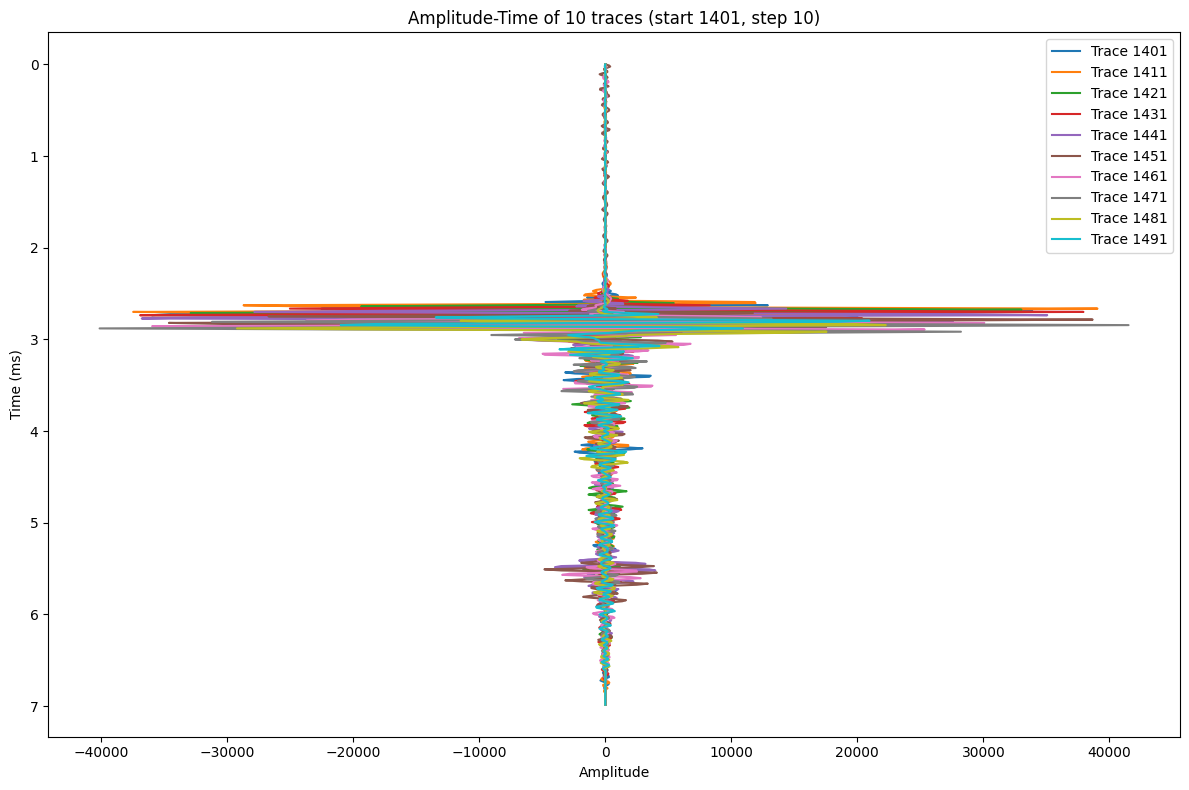

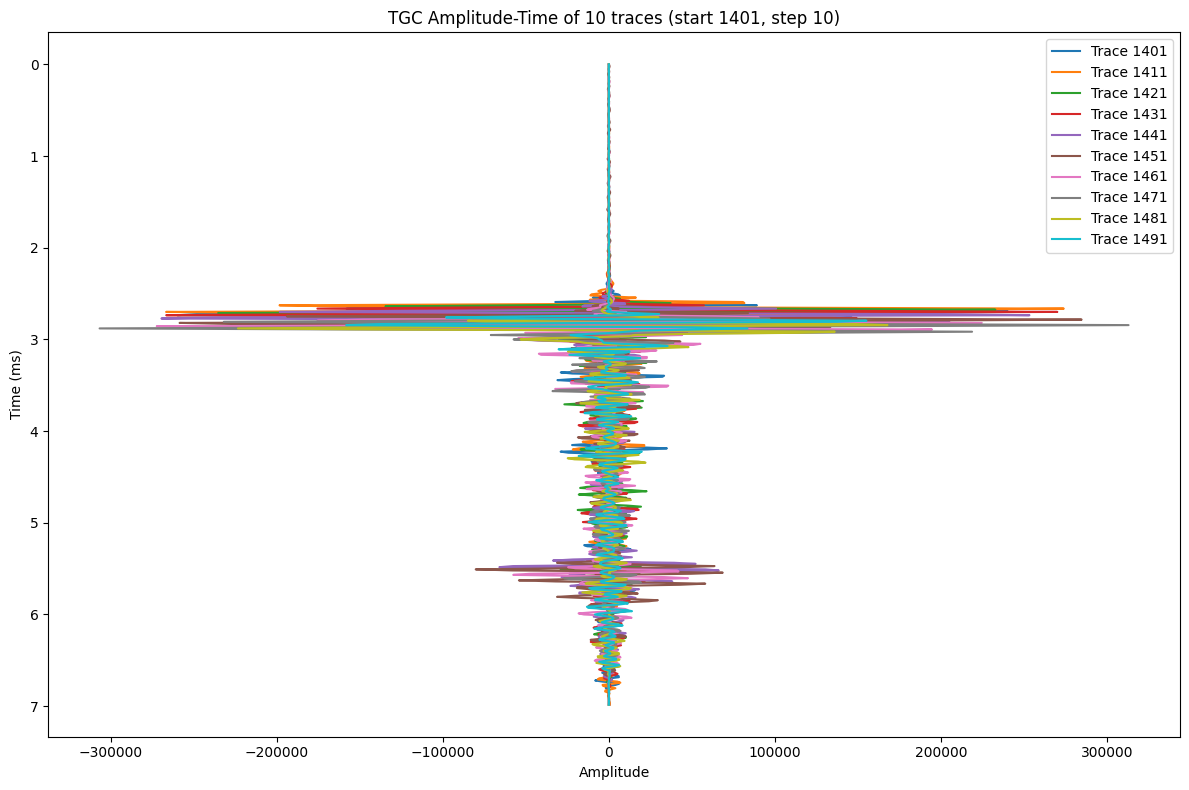

In [60]:
# --- 如你已读取 sf/dt_ms，可把这一段注释掉 ---
from obspy.io.segy.segy import _read_segy
SEGY_PATH = "processed/output_bp_5k_20k.sgy"
sf = _read_segy(SEGY_PATH, headonly=False)
# 采样间隔（毫秒）
try:
    dt_ms = sf.binary_file_header.sample_interval_in_microseconds / 1000.0
except Exception:
    dt_ms = sf.traces[0].stats.delta * 1000.0

import numpy as np
import matplotlib.pyplot as plt

# -------- TGC 核心函数 --------
def tgc_powerlaw(x, dt_ms, n=1.5, t0_ms=1.0):
    t = np.arange(x.size, dtype=np.float32) * (dt_ms)
    g = np.power(t + t0_ms, n, dtype=np.float32)
    return x.astype(np.float32) * g

def tgc_exponential(x, dt_ms, alpha=0.5):
    t = np.arange(x.size, dtype=np.float32) * (dt_ms)
    g = np.exp(alpha * t, dtype=np.float32)
    return x.astype(np.float32) * g

def apply_tgc_section(section, dt_ms, mode="power", **kwargs):
    out = np.empty_like(section, dtype=np.float32)
    for i in range(section.shape[1]):
        tr = section[:, i]
        if mode == "power":
            out[:, i] = tgc_powerlaw(tr, dt_ms, **kwargs)
        else:
            out[:, i] = tgc_exponential(tr, dt_ms, **kwargs)
    return out

# -------- 读区间成 2D 剖面（时间×道），自动补零对齐 --------
def load_section(sf, start_trace, end_trace):
    n_traces = len(sf.traces)
    idxs = range(start_trace, min(end_trace+1, n_traces))
    lengths = [sf.traces[i].data.size for i in idxs]
    ns = max(lengths)
    sec = np.zeros((ns, len(idxs)), dtype=np.float32)
    for j, i in enumerate(idxs):
        d = sf.traces[i].data.astype(np.float32)
        sec[:d.size, j] = d
    return sec, list(idxs)

# ========== 配置：选择区间 + TGC 参数 ==========
start_trace = 1000
end_trace   = 1800

tgc_mode   = "power"     # "power" 或 "exp"
power_pars = dict(n=1.5, t0_ms=1.0)
exp_pars   = dict(alpha=0.005)

# ========== 加载区间 & 计算 TGC ==========
section_raw, trace_ids = load_section(sf, start_trace, end_trace)
section_tgc = apply_tgc_section(
    section_raw, dt_ms,
    mode=tgc_mode,
    **(power_pars if tgc_mode=="power" else exp_pars)
)

# 统一对比度显示（用合并后的 p99）
p99 = np.percentile(np.abs(np.concatenate([section_raw.ravel(), section_tgc.ravel()])), 99)
sec_raw_disp = section_raw if p99==0 else np.clip(section_raw/p99, -1, 1)
sec_tgc_disp = section_tgc if p99==0 else np.clip(section_tgc/p99, -1, 1)
times_ms = np.arange(section_raw.shape[0]) * dt_ms
extent = [trace_ids[0]+1, trace_ids[-1]+1, times_ms[-1], 0]

# ========== 图1：Raw vs TGC（2D 剖面对比）==========
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
axes[0].imshow(sec_raw_disp, aspect='auto', extent=extent, cmap="gray")
axes[0].set_title(f"RAW — Traces {trace_ids[0]+1}–{trace_ids[-1]+1}")
axes[0].set_ylabel("Time (ms)")
# axes[0].invert_yaxis()

axes[1].imshow(sec_tgc_disp, aspect='auto', extent=extent, cmap="gray")
if tgc_mode == "power":
    axes[1].set_title(f"TGC (power: n={power_pars['n']}, t0={power_pars['t0_ms']} ms)")
else:
    axes[1].set_title(f"TGC (exp: α={exp_pars['alpha']})")
axes[1].set_xlabel("Trace number")
axes[1].set_ylabel("Time (ms)")
# axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# ========== （可选）图2：单道对比，便于调参 ==========
# trace_idx = trace_ids[len(trace_ids)//2]  # 取中间一条看看
trace_idx = 1450
raw = sf.traces[trace_idx].data.astype(np.float32)
tgc = tgc_powerlaw(raw, dt_ms, **power_pars) if tgc_mode=="power" else tgc_exponential(raw, dt_ms, **exp_pars)
t = np.arange(raw.size) * dt_ms

plt.figure(figsize=(10,6))
plt.plot(raw, t, label=f"Raw (trace {trace_idx+1})", alpha=0.8)
plt.plot(tgc, t, label="After TGC", alpha=0.8)
plt.gca().invert_yaxis()
plt.xlabel("Amplitude")
plt.ylabel("Time (ms)")
plt.title("Single-trace comparison: Raw vs TGC")
plt.legend()
plt.tight_layout()
plt.show()

# ====== Wiggle style: 画给定范围内的 N 条道，每隔 step 取一条 ======
trace_start = 1400   # 起始 trace
step        = 5     # 每隔多少条取一条
n_waveforms = 15     # 总共画多少条
trace_indices = [trace_start + i*step for i in range(n_waveforms) if trace_start + i*step < len(sf.traces)]

plt.figure(figsize=(4, 6))
amp_scale = 2000   # 控制摆动幅度
baseline_gap = 2000  # 控制平移距离

for k, idx in enumerate(trace_indices):
    tr = sf.traces[idx].data.astype(np.float32)
    t  = np.arange(tr.size) * dt_ms

    # Normalize each trace individually to [-1, 1]（用99分位避免极值）
    p99 = np.percentile(np.abs(tr), 99)
    if p99 > 0:
        tr = tr / p99

    # wiggle 样式：加负号保证相位方向符合常见显示
    plt.plot(-tr * amp_scale + k*baseline_gap, t, color="black")

# 横坐标对齐到 trace 编号
plt.xticks(
    ticks=[k*baseline_gap for k in range(len(trace_indices))],
    labels=[idx+1 for idx in trace_indices]
)
plt.gca().invert_yaxis()
plt.xlabel("Trace number (shifted baseline)")
plt.ylabel("Time (ms)")
plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(normalized wiggle style)")
plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# ====== Wiggle style: 画给定范围内的 N 条道（用 TGC 后的数据） ======
# trace_start = 1400   # 起始 trace
# step        = 7     # 每隔多少条取一条
# n_waveforms = 10     # 总共画多少条
# trace_indices = [trace_start + i*step for i in range(n_waveforms) if trace_start + i*step < len(sf.traces)]

plt.figure(figsize=(4, 6))
amp_scale = 2000      # 控制 wiggle 最大摆动
baseline_gap = 2000   # 控制左右平移距离

for k, idx in enumerate(trace_indices):
    if idx in trace_ids:                # 确保 idx 在当前 section 范围
        j = trace_ids.index(idx)        # 找到对应在 section_tgc 中的列
        tr = section_tgc[:, j]          # 从 TGC 后的 section 拿数据
        t  = np.arange(tr.size) * dt_ms

        # Normalize each trace individually to [-1, 1]
        p99 = np.percentile(np.abs(tr), 99)
        if p99 > 0:
            tr = tr / p99

        # wiggle 样式
        plt.plot(-tr * amp_scale + k*baseline_gap, t, color="black")

# 横坐标对齐 trace 编号
plt.xticks(
    ticks=[k*baseline_gap for k in range(len(trace_indices))],
    labels=[idx+1 for idx in trace_indices]
)
plt.gca().invert_yaxis()
plt.xlabel("Trace number (shifted baseline)")
plt.ylabel("Time (ms)")
plt.title(f"TGC Wiggle: {n_waveforms} traces, starting {trace_start+1}, every {step} traces")
plt.tight_layout()
plt.show()

def plot_traces(sf, dt_ms, start_trace1=1400, end_trace1=1500, step=10, n_show=10):
    """
    从 SEG-Y 文件对象 sf 中画 amplitude-time 曲线
    - start_trace: 起始 trace 编号（从 0 开始）
    - end_trace:   结束 trace 编号（包含）
    - step:        每隔多少条取一个 trace
    - n_show:      总共画多少条
    """
    # 生成 trace 索引
    trace_indices = [start_trace1 + i*step for i in range(n_show) if start_trace1 + i*step <= end_trace1]

    plt.figure(figsize=(12, 8))
    for idx in trace_indices:
        tr = sf.traces[idx].data.astype(np.float32)
        t = np.arange(tr.size) * dt_ms
        plt.plot(tr, t, label=f"Trace {idx+1}")
    
    plt.gca().invert_yaxis()
    plt.xlabel("Amplitude")
    plt.ylabel("Time (ms)")
    plt.title(f"Amplitude-Time of {len(trace_indices)} traces "
              f"(start {start_trace1+1}, step {step})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== 使用示例 ====
plot_traces(sf, dt_ms, start_trace1=1400, end_trace1=1500, step=10, n_show=10)
def plot_traces_tgc(section_tgc, trace_ids, dt_ms, start_trace1=1400, end_trace1=1500, step=10, n_show=10):
    """
    从 TGC 后的 section 里画 amplitude-time 曲线
    - section_tgc: apply_tgc_section 输出的 2D 数组 (ns × n_traces)
    - trace_ids:   load_section 返回的 trace 索引列表
    """
    # 找出在 trace_ids 范围内的索引
    trace_indices = [start_trace1 + i*step for i in range(n_show) if start_trace1 + i*step <= end_trace1]

    plt.figure(figsize=(12, 8))
    for idx in trace_indices:
        if idx in trace_ids:
            j = trace_ids.index(idx)   # 找到对应在 section_tgc 里的列号
            tr = section_tgc[:, j]
            t = np.arange(tr.size) * dt_ms
            plt.plot(tr, t, label=f"Trace {idx+1}")
    
    plt.gca().invert_yaxis()
    plt.xlabel("Amplitude")
    plt.ylabel("Time (ms)")
    plt.title(f"TGC Amplitude-Time of {len(trace_indices)} traces "
              f"(start {start_trace1+1}, step {step})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== 使用示例 ====
plot_traces_tgc(section_tgc, trace_ids, dt_ms,
                start_trace1=1400, end_trace1=1500, step=10, n_show=10)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, medfilt, savgol_filter

# ---------- 基础工具 ----------
def envelope(x):
    return np.abs(hilbert(x))

def seabed_pick(trace, t_ms, sigma=3.0, min_ms=0.0):
    """最简单海床拾取：包络>阈值的第一个峰；失败则用最大值"""
    env = envelope(trace.copy())
    mask = t_ms >= min_ms
    env[~mask] = 0.0
    mu, sd = np.mean(env[mask]), np.std(env[mask]) + 1e-9
    thr = mu + sigma * sd
    idx = np.argmax(env > thr)
    if env[idx] > thr:
        return idx
    return np.argmax(env)

def collect_ridge_times(section, dt_ms, gate_ms=(0.5, 4.0), smooth="median", k=5):
    """
    对每条道：
      1) 拾床；
      2) 在床后 gate_ms=(start,len) 窗内找包络峰时间；
      3) 可选平滑 ridge（median 或 savgol）。
    返回：ridge_times_ms (长度 = ntraces)
    """
    ns, ntr = section.shape
    t_ms = np.arange(ns) * dt_ms
    g0, gl = gate_ms
    ridge = np.full(ntr, np.nan, dtype=np.float32)

    for j in range(ntr):
        tr = section[:, j]
        i_bed = seabed_pick(tr, t_ms, sigma=3.0, min_ms=0.0)
        i0 = int(i_bed + g0 / dt_ms)
        i1 = int(i0   + gl / dt_ms)
        i0 = max(0, i0); i1 = min(ns, i1)
        if i1 - i0 < 32:
            continue
        win = tr[i0:i1]
        # 局部去毛刺
        win_s = medfilt(win, kernel_size=(k if k % 2 else k+1))
        idx_local = i0 + np.argmax(envelope(win_s))
        ridge[j] = idx_local * dt_ms

    # 全局平滑（可选）
    valid = ~np.isnan(ridge)
    if valid.sum() >= 7:
        if smooth == "median":
            r = ridge.copy()
            r[valid] = medfilt(ridge[valid], kernel_size=(k if k % 2 else k+1))
            ridge = r
        elif smooth == "savgol":
            r = ridge.copy()
            x = np.flatnonzero(valid)
            y = ridge[valid]
            # 只对有效段做 Savitzky–Golay
            win = min(11, (len(y)//2)*2+1)  # 奇数窗
            r[valid] = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
            ridge = r
    return ridge  # 单位：ms

def quad_fit(x, t):
    """
    拟合 t(x) = a(x - x0)^2 + t0
    令 y = t, ϕ = [x^2, x, 1] → 拟合 y = A x^2 + B x + C
    然后换算 a, x0, t0 ： a = A, x0 = -B/(2A), t0 = C - B^2/(4A)
    返回 (a, x0, t0, R^2)
    """
    X = np.vstack([x**2, x, np.ones_like(x)]).T
    beta, *_ = np.linalg.lstsq(X, t, rcond=None)  # A, B, C
    A, B, C = beta
    t_hat = X @ beta
    ss_res = np.sum((t - t_hat)**2)
    ss_tot = np.sum((t - np.mean(t))**2) + 1e-12
    R2 = 1 - ss_res/ss_tot
    if abs(A) < 1e-12:
        return None, None, None, 0.0
    x0 = -B / (2*A)
    t0 = C - B**2 / (4*A)
    return A, x0, t0, R2

# ---------- 主函数：二次曲线法检测 hyperbola ----------
def detect_hyperbola_quad(section_tgc, trace_ids, dt_ms,
                          gate_ms=(0.5, 4.0),
                          smooth="median", k=5,
                          deriv_smooth_win=7,      # 计算 dt/dx 前先平滑
                          fit_half_width=12,       # 在 apex 两侧各取多少个点拟合
                          min_points=10,           # 拟合至少需要的点数
                          R2_thresh=0.90,          # 二次拟合的 R^2 阈值
                          a_min=1e-6,              # a>0（开口向上），且不太小
                          plot=True):
    """
    返回：字典 {detected, apex_trace, apex_time_ms, a, x0, t0, R2}；并可画图
    """
    ntr = section_tgc.shape[1]
    # 1) 床后 ridge（ms）
    ridge = collect_ridge_times(section_tgc, dt_ms, gate_ms=gate_ms, smooth=smooth, k=k)
    valid = ~np.isnan(ridge)
    if valid.sum() < min_points:
        return {"detected": False, "reason": "not enough ridge points"}

    # 2) 找 apex：dt/dx 从负到正换号（在 ridge 最小附近）
    x = np.array(trace_ids)[valid].astype(float)
    y = ridge[valid].astype(float)

    # 为了稳健，先对 y 做轻微平滑后算梯度
    win = min(deriv_smooth_win, (len(y)//2)*2+1)  # 奇数
    y_smooth = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
    dy_dx = np.gradient(y_smooth, x)

    # 先找 y 的最小处作为候选 apex，再在附近找 dy/dx 的换号点
    i_min = np.argmin(y_smooth)
    # 找到从左<0 到右>0 的最接近 i_min 的换号
    sign = np.sign(dy_dx)
    zero_cross = np.where((sign[:-1] < 0) & (sign[1:] > 0))[0]  # 负->正
    if zero_cross.size == 0:
        return {"detected": False, "reason": "no negative-to-positive slope change"}

    # 取离 i_min 最近的换号点作为 apex 位置
    i0 = zero_cross[np.argmin(np.abs(zero_cross - i_min))]
    j0 = i0  # 左点索引
    apex_x = 0.5 * (x[j0] + x[j0+1])
    apex_t = 0.5 * (y_smooth[j0] + y_smooth[j0+1])

    # 3) 在 apex 两侧各取窗口做二次拟合
    #    只取靠近 apex 的有效点，避免远处弯曲/干扰
    left  = max(0, i0 - fit_half_width)
    right = min(len(x), i0 + 1 + fit_half_width)
    x_fit = x[left:right]
    t_fit = y[left:right]
    if x_fit.size < min_points:
        return {"detected": False, "reason": "not enough points around apex"}

    a, x0, t0, R2 = quad_fit(x_fit, t_fit)
    if a is None or a <= a_min or R2 < R2_thresh:
        return {"detected": False, "reason": f"poor quad fit (a={a}, R2={R2:.2f})"}

    result = {
        "detected": True,
        "apex_trace": float(apex_x),
        "apex_time_ms": float(apex_t),
        "a": float(a), "x0": float(x0), "t0": float(t0), "R2": float(R2),
        "gate_ms": gate_ms
    }

    if plot:
        # (1) ridge & dt/dx
        fig, ax = plt.subplots(1,2, figsize=(11,4))
        ax[0].plot(x, y, 'k.', ms=4, label="ridge (ms)")
        ax[0].plot(x, y_smooth, 'C0-', lw=2, label="smoothed")
        ax[0].axvline(apex_x, color='r', ls='--', label="apex (dt/dx change)")
        ax[0].invert_yaxis()
        ax[0].set_xlabel("Trace number"); ax[0].set_ylabel("Time (ms)")
        ax[0].legend(); ax[0].set_title("Ridge & apex")

        ax[1].plot(x, dy_dx, 'C1-'); ax[1].axhline(0, color='k', lw=1)
        ax[1].axvline(apex_x, color='r', ls='--')
        ax[1].set_xlabel("Trace number"); ax[1].set_ylabel("dt/dx (ms/trace)")
        ax[1].set_title("Slope (dt/dx)")

        plt.tight_layout(); plt.show()

        # (2) 二次拟合可视化
        xx = np.linspace(x_fit.min(), x_fit.max(), 200)
        tt = a*(xx - x0)**2 + t0
        plt.figure(figsize=(6,5))
        plt.plot(x_fit, t_fit, 'k.', ms=5, label="fit window (ridge)")
        plt.plot(xx, tt, 'r-', lw=2, label=f"quad fit (R²={R2:.2f})")
        plt.scatter([apex_x],[apex_t], c='g', s=40, label="apex")
        plt.gca().invert_yaxis()
        plt.xlabel("Trace number"); plt.ylabel("Time (ms)")
        plt.legend(); plt.title("Quadratic fit around apex")
        plt.tight_layout(); plt.show()

    import numpy as np
import matplotlib.pyplot as plt

def plot_hyperbola_fit(section, trace_ids, dt_ms, ridge_points, quad_params, window=(0, None)):
    """
    section: 2D array (ns × ntr)
    trace_ids: trace numbers
    dt_ms: sample interval in ms
    ridge_points: list of (trace_idx, sample_idx)
    quad_params: (a, x0, t0) from quadratic fit
    """
    ns, ntr = section.shape
    times_ms = np.arange(ns) * dt_ms
    extent = [trace_ids[0]+1, trace_ids[-1]+1, times_ms[-1], times_ms[0]]  # 上 0ms，下更大

    # 显示剖面
    p99 = np.percentile(np.abs(section), 99)
    disp = section if p99 == 0 else np.clip(section/p99, -1, 1)

    plt.figure(figsize=(10,6))
    plt.imshow(disp, aspect="auto", extent=extent, cmap="gray")

    # ridge 点
    if ridge_points:
        xs = [trace_ids[i]+1 for i,j in ridge_points]
        ys = [j*dt_ms for i,j in ridge_points]
        plt.scatter(xs, ys, color="red", s=20, label="ridge points")

    # 二次曲线拟合
    if quad_params is not None:
        a, x0, t0 = quad_params
        xx = np.linspace(trace_ids[0]+1, trace_ids[-1]+1, 200)
        yy = a*(xx-x0)**2 + t0
        plt.plot(xx, yy, "c--", lw=2, label="quad fit")

    plt.gca().invert_yaxis()
    plt.xlabel("Trace number")
    plt.ylabel("Time (ms)")
    plt.title("Hyperbola detection (ridge + quad fit)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return result

In [67]:
res = detect_hyperbola_quad(
    section_tgc, trace_ids, dt_ms,
    gate_ms=(0.5, 4.0),
    smooth="median", k=5,
    deriv_smooth_win=7,
    fit_half_width=12,
    min_points=10,
    R2_thresh=0.90, a_min=1e-6,
    plot=False   # 注意这里先关掉内部 plot
)

if res["detected"]:
    plot_hyperbola_fit(
        section_tgc,
        trace_ids,
        dt_ms,
        res.get("ridge_points"),
        res.get("quad_params")
    )
else:
    print("未检测到 hyperbola:", res["reason"])

UnboundLocalError: local variable 'np' referenced before assignment